## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Red neuronal profunda


### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

En este cuadernos estudiaremos las redes profundas. Implementaremos nuestra propia red utilizando la biblioteca (API) Keras (https://keras.io/).   

Identificaremos nuestros mejores modelos según la arquitectura de red, intentando redes multi-capa densamente conectadas y haciendo uso de regularización para el cálculo de su función de pérdida. 

Probaremos nuestros modelos más complejos de *deep learning* para la detección automática de frailejones sobre imagenes aereas del páramo e intentaremos mejorar los resultados que obtuvimos con nuestras redes más sencillas. Recordemos que hasta ahora hemos logrado unos resultados preliminares con un *accuracy* de validación de 0.86, utilizando una red sencilla de 5 neuronas. 

## Integrantes:

- Ivan Galindo Gaviria Cod: 201924193

- Jonny Coronel Villamil Cod: 201411692

- Sergio Ardila Rodríguez Cod: 201924139

Importemos algunos de los paquetes que vamos a utilizar:


In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from ImportImagenesRGB import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from prettytable import PrettyTable
import datetime

import keras
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from keras.layers import Activation, Dropout, Flatten, Dense

from numpy.random import seed
seed(1)


Using TensorFlow backend.


## 1. Redes , Validación cruzada doble (DVC) y GD estocástico (SGD)

A continuacion repliquemos el modelo de red sencilla con 5 neuronas que ya construimos paso a paso en clases anteriores. Pero esta vez utilizando la funcion `model`de Keras, que añade capas secuencialmente.

###  Validación cruzada doble (DCV)
Repetimos varias veces el entrenamiento, validación y *prueba* de los modelos con distintas particiones de los datos, implementando una *validación cruzada doble* con el fin de obtener una estimación insesgada del error de predicción (para mayores detalles ver Filmozer et al (2009), http://www.libpls.net/publication/rdCV_2009.pdf) Esta implementación es útil cuando tenemos pocos datos.

### Descenso en la Dirección del Gradiente Estocástico (SGD) 
Para esta primera red sencilla, el proceso de optimización lo vamos a implementar de acuerdo con el método de Descenso en la Dirección del Gradiente Estocástico (SGD). Como ya hemos visto, el método de Descenso en la direccion del gradiente es un método iterativo que permite optimizar funciones objetivo diferenciables, donde 

$$ \hat \theta_{nuevo} = \hat \theta_{viejo} - \alpha \frac{\partial J(\hat \theta_{viejo}; X, Y) }{ \partial \hat \theta_{viejo} }$$ 

siendo $\alpha$ la tasa de aprendizaje y $\theta$ nuestro parámetro a estimar.


La parte estocástica se refiere a que en lugar de utilizar todos los datos en cada paso iterativo, utilizamos una observación (elegida de manera aleatoria) en cada paso. De esta manera, el SGD permite reducir el coste computacional del proceso de optimización, iterando más rápidamente pero con un tasa de convergencia ligeramente menor y más **oscilante**. 

Entonces, el SGD se puede formular de la siguiente manera

$$ \hat \theta_{nuevo} = \hat \theta_{viejo} - \alpha \frac{\partial J (\hat \theta_{viejo}; x^{(i)}, y^{(i)})}{ \partial \hat \theta_{viejo} }$$ 



Fijémnos que una variación del GD a *medio-camino* del SGD es el GD en *batches* o subconjuntos de datos con un tamaño dado (16, 32, 64,...), el cual optimiza sobre distintos subconjuntos (aleatoriamente seleccionados) del total de los datos en cada iteración.


Además se tienen otras modificaciones sobre el SGD. La más opular es la adición de un término de *momentum*.

### SGD con momentum

Recordando las nociones de física, el término *momentum* hace referencia al algoritmo que avanza a lo largo del espacio paramétrico en búsqueda del óptimo (local), aceleradno de acuerdo con el gradiente de la pérdida (que guardando la anlogía con la física, se refiere a la fuerza). De esta manera, modificando el GD clásico, pues mantiene la misma dirección a medida que avanza disminuyendo las oscilaciones. 

Este método hace parte de la literatura del aprendizaje computacional basado en la *retro-propagación* (Rumelhart et al. (1986) https://www.nature.com/articles/323533a0) 

El SGD con momentum actualiza los estimadores como una combinación lineal entre el gradiente y la actualización previa, implementando un promedio suavizado:


$$ \hat \theta_{nuevo} = \eta \hat \theta_{viejo} - \alpha \frac{\partial J (\hat \theta_{viejo}; x^{(i)}, y^{(i)})}{ \partial \hat \theta_{viejo} }$$ 

donde $\eta$ es el factor de decrecimiento exponencial que toma valores entre 0 y 1. Así, $\eta$ permite incorporar la contribución relativa entre el gradiente actual y de gradientes anteriores. 


A continuación importemos las imagenes:

In [2]:
X,Y = import_imagenes_RGB()

print(X.shape, Y.shape, X[0,0,0])

(250, 70, 70, 3) (1, 250) [0.58823529 0.5372549  0.40392157]


**Salida esperada:**

(250, 70, 70, 3) (1, 250) [0.58823529 0.5372549  0.40392157]


In [3]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])
Acc_E = []
Acc_V = []
Acc_P = []

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=1000

# Definimos los parametros del SGD
sgd = SGD(lr=0.01, momentum=0.001)
# junto con la inicialización aleatoria
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# inicializamos el error para guardar el mejor modelo
err_p = 999
  
# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Especificamos la arquitectura de la red 
    model = Sequential()  
    model.add(Flatten(input_shape=CE_x.shape[1:]))
    model.add(Dense(5, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False) 
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
            
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_redsencilla_initseed=1_part_seed='+str(r)+'numn=5.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' y accu_v='+str(accu_v))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])
    
    # Exactitud media
    Acc_E.append(accu_e)
    Acc_V.append(accu_v)
    Acc_P.append(accu_p)

print(x)

print('Accuracies de Entrenamiento: '+str(np.round(np.mean(Acc_E),3))
      +'; Validacion1: '+str(np.round(np.mean(Acc_V),3))+ '; Validacion2: '+str(np.round(np.mean(Acc_P),3)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoca= 671 y accu_v=0.837837815284729
Epoca= 522 y accu_v=0.837837815284729
Epoca= 332 y accu_v=0.7837837934494019
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8378 | 0.8158 |  671  |
| 0.9943 | 0.8378 | 0.7895 |  522  |
| 0.9771 | 0.7838 | 0.8421 |  332  |
+--------+--------+--------+-------+
Accuracies de Entrenamiento: 0.99; Validacion1: 0.82; Validacion2: 0.816


Graficamos el desempeño del modelo:

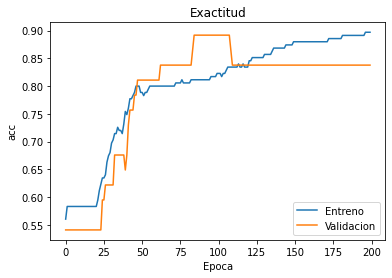

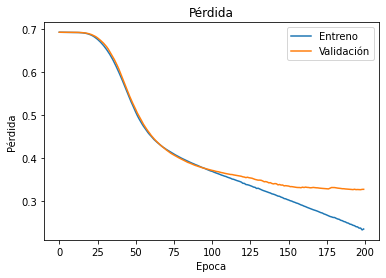

In [15]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Confirmamos que podemos cargar de nuevo el modelo que guardamos:

In [7]:
# red sencilla 5 neuronas
model_1 = load_model('modelo_redsencilla_initseed=1_part_seed=3numn=5.h5')

### Pregunta 1.1

Cuántos parámetros debemos estimar en esta red sencilla?

Se necesitan (70x70x3)x5 + 5x1 =73505 parámetros.

### Replicabilidad

Confirmamos el desempeño del modelo sobre todo el conjunto de datos:

In [8]:
Y_pred = model_1.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[141,   4],
       [  9,  96]], dtype=int64)

**Salida esperada:**
    
<table style="width:20%">
    <tr>
       <td> 140 </td>
       <td> 5 </td>
    </tr>
    <tr>
       <td> 7 </td>
       <td> 98 </td>
    </tr>

</table>

    

### Ejercicio 1.1

Busque un mejor modelo intentando diferentes inicializaciones para la estimación de los parámetros.

In [9]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])
Acc_E = []
Acc_V = []
Acc_P = []

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=1000

# Definimos los parametros del SGD
sgd = SGD(lr=0.01, momentum=0.001)
# junto con la inicialización aleatoria
#initnorm = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)
#initnorm = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
#initnorm = tf.keras.initializers.GlorotNormal(seed=1)

#Xavier
fan_in = 70 * 70 * 3
fan_out = 1
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev= np.sqrt(2 / (fan_in + fan_out)) , seed=1)



# inicializamos el error para guardar el mejor modelo
err_p = 999
  
# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Especificamos la arquitectura de la red 
    model = Sequential()  
    model.add(Flatten(input_shape=CE_x.shape[1:]))
    model.add(Dense(5, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False) 
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
            
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_redsencilla_initseed=1_part_seed='+str(r)+'numn=5.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' y accu_v='+str(accu_v))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])
    
    # Exactitud media
    Acc_E.append(accu_e)
    Acc_V.append(accu_v)
    Acc_P.append(accu_p)

print(x)

print('Accuracies de Entrenamiento: '+str(np.round(np.mean(Acc_E),3))
      +'; Validacion1: '+str(np.round(np.mean(Acc_V),3))+ '; Validacion2: '+str(np.round(np.mean(Acc_P),3)))

Epoca= 519 y accu_v=0.8108108043670654
Epoca= 461 y accu_v=0.837837815284729
Epoca= 410 y accu_v=0.8108108043670654
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8108 | 0.8158 |  519  |
| 0.9943 | 0.8378 | 0.7895 |  461  |
| 0.9771 | 0.8108 | 0.8158 |  410  |
+--------+--------+--------+-------+
Accuracies de Entrenamiento: 0.99; Validacion1: 0.82; Validacion2: 0.807


## 2. Redes profundas

Ahora implementemos una red multi-capa, añadiendo más capas al modelo. Primero definimos la técnica de inicialización de He que vimos la clase pasada, la cual está pensada para aliviar el entenamiento de redes profundas con funciones de activación basadas en los rectficadores ReLU.

Recordemos que la inicialización de He para los parametros $W^{[l]}$ consiste en multiplicar sus valores iniciales por  $\sqrt{\frac{2}{n_l}}$.


Ahora, para esta red profunda, vamos a utilizar un método de optimización que nos ayude a reducir el coste computacional que conlleva un número aumentado de parámetros a estimar.

### Propagación de la raiz cuadrada del Cuadrado Medio (RMSProp)

El método de propagación de la raiz cuadrada del cuadrado medio (RMSProp *Root Mean Square Propagation*) permite adaptar la tasa de aprendizaje para cada uno de los parámetros. Esto se hace dividiendo la tasa de aprendizaje (para un parámetro) por un promedio móvil de las magnitudes de los gradientes recientes (ver https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf ) 

De esta manera, un primer promedio movil se calcula en términos de los cuadrados medios del gradiente y el parámetro $\rho$ que representa un factor de memoria a corto plazo sobre los gradientes recientes:

$$ v(\theta) = \rho v(\theta_{viejo}) + (1-\rho) \biggr( \frac{\partial J (\hat \theta_{viejo}; x^{(i)}, y^{(i)})}{ \partial \hat \theta_{viejo} } \biggl)^2  $$


De tal manera que la actualización de los parámetros se lleva a cabo mediante:

$$ \hat \theta_{nuevo} = \hat \theta_{viejo} - \frac{\alpha}{\sqrt{v(\theta)}} \frac{\partial J (\hat \theta_{viejo}; x^{(i)}, y^{(i)})}{ \partial \hat \theta_{viejo} }$$ 

Esta implementación del RMSProp permite adaptar la tasa de aprendizaje sobre la optimización con todos los datos o pequeños subconjuntos de los datos. 


Antes de especificar la estructura de la red, primero definamos la inicializacion de He:

In [10]:
initHe = keras.initializers.he_normal(seed=1)

Veamos cómo podemos agregar más capas al modelo que definimos con la ayuda de Keras. A continuación definimos la arquitectura de la red, una con inicializacion aleatoria normal y otra con la incializacion de He:

In [11]:
model = Sequential()  
model.add(Flatten(input_shape=X.shape[1:]))
model.add(Dense(700, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))  
model.add(Dense(400, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(Dense(100, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(Dense(50, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(Dense(15, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_norm = model.get_config()

In [12]:
model = Sequential()   
model.add(Flatten(input_shape=X.shape[1:]))
model.add(Dense(700, activation='relu', kernel_initializer=initHe, bias_initializer='zeros')) 
model.add(Dense(400, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(100, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(50, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(15, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_He = model.get_config()

Ahora implementamos el codigo para buscar el mejor modelo con la arquitectura arriba definida, probando ambos métodos de incialización:

Inicio Init=Normal:2020-09-20 23:26:36.334456
Epoca= 197 , accu_v1=0.837837815284729 , accu_v2=0.8421052694320679
Fin Init= Normal:2020-09-20 23:30:28.337000


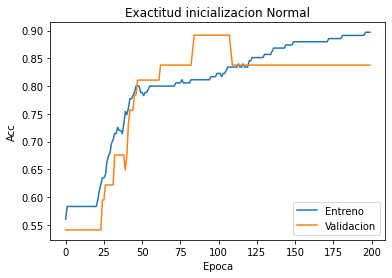

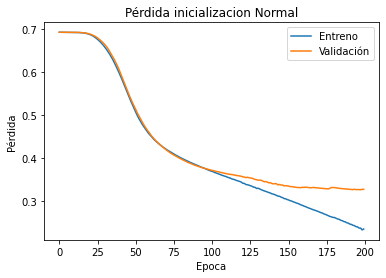

Inicio Init=He:2020-09-20 23:30:29.261847
Epoca= 176 , accu_v1=0.7837837934494019 , accu_v2=0.8684210777282715
Fin Init= He:2020-09-20 23:34:01.262107


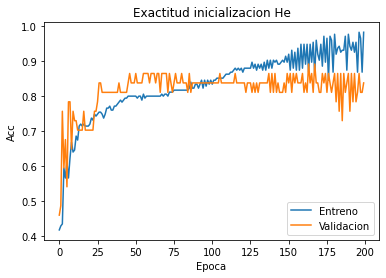

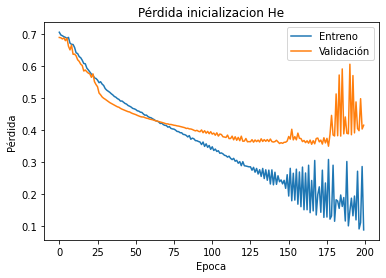

+--------+--------+--------+-------+--------+
| Exac_E | Exac_V | Exac_P | Epoca |  Init  |
+--------+--------+--------+-------+--------+
| 0.9886 | 0.8378 | 0.8421 |  197  | Normal |
|  1.0   | 0.7838 | 0.8684 |  176  |   He   |
+--------+--------+--------+-------+--------+


In [16]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca", "Init"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=200

# Definimos los parametros del RMSProp
rmsprop = keras.optimizers.RMSprop(lr=0.00008, rho=0.9)

# implementamos 2 repeticiones, una con inicializacion aleatoria Normal y otra con He
for i in range(2):
    if(i==0):
        model = Sequential.from_config(config_norm)
        init = "Normal"
        tiempo0 = datetime.datetime.now()
        print('Inicio Init=' +str(init)+':' +str(tiempo0))
    elif(i==1):
        model = Sequential.from_config(config_He)
        init = "He"
        tiempo0 = datetime.datetime.now()
        print('Inicio Init=' +str(init)+':' +str(tiempo0))
        
    # Partimos los datos en entrenamiento y doble validación
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = 8)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = 8)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)  
  
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en la primera validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
           
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    pathr =('modelo_redprofunda_initseed=1_part_seed=8_Init='+str(init)+'.h5')
    model.save(pathr) 
    err_p = loss_p
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0], init])
    
    # Imprimimos el desempeño para cada inicializacion y el tiempo en completar las iteraciones
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    tiempo1 = datetime.datetime.now()
    print('Fin Init= ' +str(init)+':' +str(tiempo1))
    
    # Graficamos el desempeño del modelo
    plt.figure(1)
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('Exactitud inicializacion ' +str(init))  
    plt.ylabel('Acc')  
    plt.xlabel('Epoca')  
    plt.legend(['Entreno', 'Validacion'], loc='lower right')
    plt.show()

    plt.figure(1) 
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('Pérdida inicializacion ' +str(init))  
    plt.ylabel('Pérdida')  
    plt.xlabel('Epoca')  
    plt.legend(['Entreno', 'Validación'], loc='upper right')  
    plt.show()

print(x)

### Pregunta 2.1

Qué método de inicialización ayuda más a la convergencia del modelo?

La inicialización aleatoria con el método de He permite que el modelo converja más rápido que la inicialización Normal con una caida más suave,  sin embargo, la convergencia del modelo mediante el método de He presenta inestabilidad.

Cargamos el mejor modelo y confirmamos el desempeño del modelo sobre todo el conjunto de datos:

In [17]:
# red profunda de 6 capas
model_2 = load_model('modelo_redprofunda_initseed=1_part_seed=8_Init=Normal.h5')

model_2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 14700)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 700)               10290700  
_________________________________________________________________
dense_14 (Dense)             (None, 400)               280400    
_________________________________________________________________
dense_15 (Dense)             (None, 100)               40100     
_________________________________________________________________
dense_16 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_17 (Dense)             (None, 15)                765       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                

In [18]:
Y_pred = model_2.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[137,   8],
       [  6,  99]], dtype=int64)

**Salida esperada (aproximada):**
    
<table style="width:20%">
    <tr>
       <td> 139 </td>
       <td> 6 </td>
    </tr>
    <tr>
       <td> 6 </td>
       <td> 99 </td>
    </tr>

</table>

### Ejercicio 2.1

Explore la implementación de regularizacion L1 y L2 sobre la última capa escondida para mejorar el desempeño en validación de la red.



*Ayuda: visite la pagina de Keras https://keras.io/regularizers/
para aplicar regularización sobre la magnitud de los parametros, implemente `kernel_regularizer`
Por ejemplo, si queremos una regularización L2 con una constante de 0.01, escribimos `kernel_regularizer=regularizers.l2(0.01)`


In [19]:
model = Sequential()  
model.add(Flatten(input_shape=X.shape[1:]))
model.add(Dense(700, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))  
model.add(Dense(400, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(100, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(50, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(15, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(1, activation='sigmoid', kernel_initializer=initHe, bias_initializer='zeros', kernel_regularizer=keras.regularizers.l1(0.01)))

# Guardamos la arquitectura de red
config_He_L1 = model.get_config()

In [20]:
model = Sequential()   
model.add(Flatten(input_shape=X.shape[1:]))
model.add(Dense(700, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(400, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(100, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(50, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(15, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros', kernel_regularizer=keras.regularizers.l2(0.03))) 
    
# Guardamos la arquitectura de red
config_He_L2 = model.get_config()

Ahora implementamos el codigo para buscar el mejor modelo con la arquitectura arriba definida, probando ambos métodos de incialización:

Inicio Init=He con Regularización L1:2020-09-20 23:38:18.342555
Epoca= 137 , accu_v1=0.8648648858070374 , accu_v2=0.8157894611358643
Fin Init= He con Regularización L1:2020-09-20 23:41:23.959721


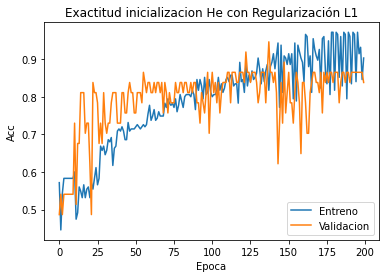

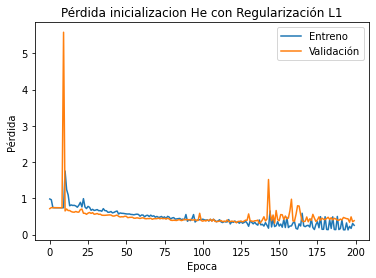

Inicio Init=He con Regularización L2:2020-09-20 23:41:25.708143
Epoca= 186 , accu_v1=0.837837815284729 , accu_v2=0.8421052694320679
Fin Init= He con Regularización L2:2020-09-20 23:45:15.004745


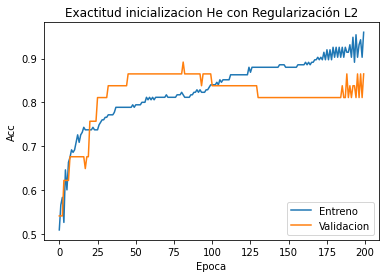

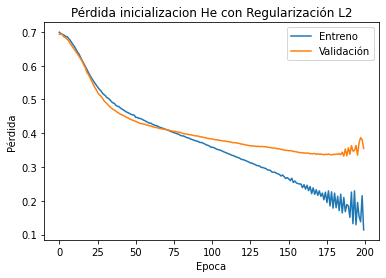

+--------+--------+--------+-------+--------------------------+
| Exac_E | Exac_V | Exac_P | Epoca |           Init           |
+--------+--------+--------+-------+--------------------------+
|  1.0   | 0.8649 | 0.8158 |  137  | He con Regularización L1 |
|  1.0   | 0.8378 | 0.8421 |  186  | He con Regularización L2 |
+--------+--------+--------+-------+--------------------------+


In [22]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca", "Init"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=200

# Definimos los parametros del RMSProp
rmsprop = keras.optimizers.RMSprop(lr=0.00008, rho=0.9)

# implementamos 2 repeticiones, una con inicializacion aleatoria Normal y otra con He
for i in range(2):
    if(i==0):
        model = Sequential.from_config(config_He_L1)
        init = "He con Regularización L1"
        tiempo0 = datetime.datetime.now()
        print('Inicio Init=' +str(init)+':' +str(tiempo0))
    elif(i==1):
        model = Sequential.from_config(config_He_L2)
        init = "He con Regularización L2"
        tiempo0 = datetime.datetime.now()
        print('Inicio Init=' +str(init)+':' +str(tiempo0))
        
    # Partimos los datos en entrenamiento y doble validación
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = 8)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = 8)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)  
  
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
    # Conseguimos el mejor modelo de acuerdo con su desempeño en la primera validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
           
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    pathr =('modelo_redprofunda_initseed=1_part_seed=8_Init='+str(init)+'.h5')
    model.save(pathr) 
    err_p = loss_p
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0], init])
    
    # Imprimimos el desempeño para cada inicializacion y el tiempo en completar las iteraciones
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    tiempo1 = datetime.datetime.now()
    print('Fin Init= ' +str(init)+':' +str(tiempo1))
    
    # Graficamos el desempeño del modelo
    plt.figure(1)
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('Exactitud inicializacion ' +str(init))  
    plt.ylabel('Acc')  
    plt.xlabel('Epoca')  
    plt.legend(['Entreno', 'Validacion'], loc='lower right')
    plt.show()

    plt.figure(1) 
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('Pérdida inicializacion ' +str(init))  
    plt.ylabel('Pérdida')  
    plt.xlabel('Epoca')  
    plt.legend(['Entreno', 'Validación'], loc='upper right')  
    plt.show()

print(x)

## Ejercicio 2.2

Revise los métodos de inicialización, el procedimiento de optimización, la arquitectura de la red y/o las funciones de activación, e intente mejorar los resultados que acabamos de obtener. Lectura avanzada sobre métodos de optimización en redes profundas: https://openreview.net/pdf?id=ryQu7f-RZ
http://www.cs.utoronto.ca/~ilya/pubs/2013/1051_2.pdf

In [ ]:
model = Sequential()    
model.add(Flatten(input_shape=X.shape[1:])) 
model.add(Dense(800, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(400, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(100, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(50, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(25, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros', kernel_regularizer=keras.regularizers.l1_l2(l1=0.03, l2=0.01))) 
    
# Guardamos la arquitectura de red
config_He_Best = model.get_config()

In [ ]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca", "Init"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=200

# Definimos los parametros del RMSProp
rmsprop = keras.optimizers.RMSprop(lr=0.0008, rho=0.9)

# implementamos 2 repeticiones, una con inicializacion aleatoria Normal y otra con He

model = Sequential.from_config(config_He_Best)
init = "He Mejorado"
tiempo0 = datetime.datetime.now()
print('Inicio Init=' +str(init)+':' +str(tiempo0))

        
# Partimos los datos en entrenamiento y doble validación
CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = 8)
CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = 8)
    
# Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])
    
# Ajustamos el modelo
history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)  
  
# Encontramos el mejor modelo en validación
min_err=np.min(history.history['val_loss'])
best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
# Conseguimos el mejor modelo de acuerdo con su desempeño en la primera validación
model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
# Calculamos las metricas
train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
           
# Guardamos las métricas de desempeño
accu_e = train_metrics[1]
loss_e = train_metrics[0]
accu_v = valid_metrics[1]
loss_v = valid_metrics[0]
accu_p = test_metrics[1]
loss_p = test_metrics[0]
    
pathr =('modelo_redprofunda_initseed=1_part_seed=8_Init='+str(init)+'.h5')
model.save(pathr) 
err_p = loss_p
    
x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0], init])
    
# Imprimimos el desempeño para cada inicializacion y el tiempo en completar las iteraciones
print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
tiempo1 = datetime.datetime.now()
print('Fin Init= ' +str(init)+':' +str(tiempo1))
    
# Graficamos el desempeño del modelo
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud inicializacion ' +str(init))  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida inicializacion ' +str(init))  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

print(x)    

In [ ]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca", "Init"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=200

# Definimos los parametros del Adam
rmsprop = keras.optimizers.Adam(lr=0.0008)

# implementamos 2 repeticiones, una con inicializacion aleatoria Normal y otra con He

model = Sequential.from_config(config_He_Best)
init = "He Mejorado"
tiempo0 = datetime.datetime.now()
print('Inicio Init=' +str(init)+':' +str(tiempo0))

        
# Partimos los datos en entrenamiento y doble validación
CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = 8)
CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = 8)
    
# Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])
    
# Ajustamos el modelo
history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)  
  
# Encontramos el mejor modelo en validación
min_err=np.min(history.history['val_loss'])
best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
        
# Conseguimos el mejor modelo de acuerdo con su desempeño en la primera validación
model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
# Calculamos las metricas
train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
           
# Guardamos las métricas de desempeño
accu_e = train_metrics[1]
loss_e = train_metrics[0]
accu_v = valid_metrics[1]
loss_v = valid_metrics[0]
accu_p = test_metrics[1]
loss_p = test_metrics[0]
    
pathr =('modelo_redprofunda_initseed=1_part_seed=8_Init='+str(init)+'.h5')
model.save(pathr) 
err_p = loss_p
    
x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0], init])
    
# Imprimimos el desempeño para cada inicializacion y el tiempo en completar las iteraciones
print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
tiempo1 = datetime.datetime.now()
print('Fin Init= ' +str(init)+':' +str(tiempo1))
    
# Graficamos el desempeño del modelo
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud inicializacion ' +str(init))  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida inicializacion ' +str(init))  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

print(x)    

Conseguimos mejorar el modelo cambiando la cantidad de capas y neuronas en la red, así como la penalidad

## 3. Caso aplicado

Ahora probemos nuestro modelo sobre la imagen completa de prueba del paramo ``IMG_3451.JPG``.


In [ ]:
from keras.preprocessing.image import image

img = image.load_img('IMG_3451.JPG')
#img 

### 3.1 Red sencilla

In [ ]:
# Lo pasamos por nuestra imagen de prueba
x = np.array(img)
x2 = x

ni = x.shape[0]-50
mi = x.shape[1]-50

f1=0
f2=70
for i in range(1,ni,50):
    c1=0
    c2=70
    for j in range(1,mi,50):
        subi=x[f1:f2,c1:c2,]/255.
        subi2=np.expand_dims(subi,0)
        Y_preds = model_1.predict(subi2)
        pred_P = (Y_preds > 0.5)
        if(pred_P==1):
            x2[f1:f2,c1:c2,2]=0
        c1=c1+50
        c2=c2+50
    f1=f1+50
    f2=f2+50
        
plt.figure(figsize = (20,20))
plt.imshow(x2)

### 3.2 Red multi-capa

In [ ]:
# Lo pasamos por nuestra imagen de prueba
x = np.array(img)
x2 = x

ni = x.shape[0]-50
mi = x.shape[1]-50

f1=0
f2=70
for i in range(1,ni,50):
    c1=0
    c2=70
    for j in range(1,mi,50):
        subi=x[f1:f2,c1:c2,]/255.
        subi2=np.expand_dims(subi,0)
        Y_preds = model_2.predict(subi2)
        pred_P = (Y_preds > 0.5)
        if(pred_P==1):
            x2[f1:f2,c1:c2,2]=0
        c1=c1+50
        c2=c2+50
    f1=f1+50
    f2=f2+50
        
plt.figure(figsize = (20,20))
plt.imshow(x2)

### Pregunta

Qué puede observar sobre el desempeño de los diferentes modelos? Qué estrategias puede proponer para mejorar los modelos?

El desempeño de los modelos tomando como referencia los anteriormente aplicados en las actividades anteriores mejora con la aplicación directa sobre Keras. Así mismo, es evidente tanto por las medidas de accuracy previamente obtenidas, cómo por simple inspección, que el modelo multi-capa es mejor que la red sencilla. Sin embargo, el proceso de tunning sigue siendo la parte más importante en el modelado. Establecer los parámetros de tasa de aprendizaje, momentum, número de capas, número de neuronas, optimizador, penalización e inicialización de los estimadores para obtener el mejor modelo es complejo, tanto por los tiempos de ejecución que se tienen para cada prueba (capacidad de maquina) como para encontrar esas relaciones mátematicas que facilitan encontrar esos primeros puntos de referencia para la selección de parámetros. En si, en las pruebas realizadas el común denominador fue empezar a encontrar inestabilidad en los mejores accuracy. Para intentar mejorar este modelo sería más conveniente dejar el tunning, que se presenta costoso, y pensar en otros modelos de redes profundas, como las convolucionales. Estas últimas han ganado mucho terreno en el campo de las imagénes. 